In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
!pip install category_encoders

In [ ]:
!pip install feature-engine

In [129]:
import pandas as pd
import numpy as np
from category_encoders import TargetEncoder
from category_encoders import HashingEncoder
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, precision_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, BaggingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from feature_engine.encoding import CountFrequencyEncoder, MeanEncoder, RareLabelEncoder, OrdinalEncoder


In [ ]:
!pip install imbalanced-learn

In [ ]:
!pip uninstall scikit-learn --yes
!pip uninstall imblearn --yes
!pip install scikit-learn==1.2.2
!pip install imblearn

In [1]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN

In [149]:
data = pd.read_csv('fraud_test.csv')


In [150]:
y = data["is_fraud"]
X = data.drop(['is_fraud'],axis=1)

In [151]:
#Modify columns
X_used = X.drop(['Unnamed: 0','street','city','state','cc_num', 'unix_time', 'trans_num'], axis=1)
X_used[['date', 'time']] = X_used['trans_date_trans_time'].str.split(' ', expand=True)
X_used[['day', 'month', 'year']] = X_used['date'].str.split('/', expand=True)
X_used['time'] = X_used['time'].apply(lambda x: x.split(':')[0])
X_used['dob'] = X_used['dob'].apply(lambda x: x.split('/')[-1])
X_used["gender"] = X_used["gender"].replace({'M': 0, 'F': 1})
X_used = X_used.drop(['trans_date_trans_time','date'], axis=1)

<ipython-input-151-ee95265836cb>:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_used["gender"] = X_used["gender"].replace({'M': 0, 'F': 1})


In [ ]:
print(X_used)

In [152]:
used_data = X_used.copy()
used_data['is_fraud'] = y

In [ ]:
print(used_data)

In [153]:
features = used_data.select_dtypes(np.object_).columns
cat_features = []
for feature in features:
    used_data[feature] = used_data[feature].astype('category')
    cat_features.append(feature)

In [154]:
X_train, X_test, y_train, y_test = train_test_split(used_data.drop('is_fraud', axis = 1),
                                                    used_data['is_fraud'],
                                                    stratify = used_data['is_fraud'],
                                                    test_size = 0.25)

In [155]:
train_data = X_train.copy()
train_data['is_fraud'] = y_train

<ipython-input-156-69342c6395cb>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='is_fraud', data=train_data, palette=colors)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

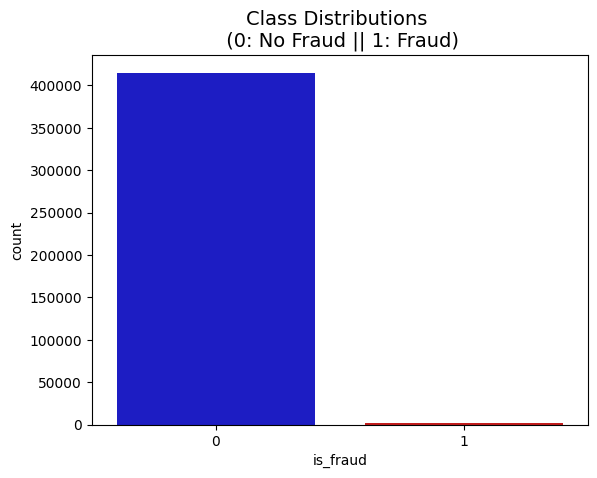

In [156]:
#Show plot
import matplotlib.pyplot as plt
colors = ["#0101DF", "#DF0101"]
sns.countplot(x='is_fraud', data=train_data, palette=colors)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

In [ ]:
print(train_data.dtypes)

In [157]:
target_encoder = TargetEncoder()
train_data[cat_features] = target_encoder.fit_transform(train_data[cat_features], train_data["is_fraud"])

In [158]:
train_data.head()

,merchant,category,amt,first,last,gender,zip,lat,long,city_pop,job,dob,merch_lat,merch_long,time,day,month,year,is_fraud
145087,6.548461e-14,0.002299,4.78,0.002077,0.004695,0,38922,33.9215,-89.6782,3451,0.000000,0.003051,33.481092,-90.185902,0.001042,0.002961,0.004501,0.00386,0
170193,5.347556e-13,0.002299,9.89,0.006217,0.000000,1,97403,44.0385,-123.0614,191096,0.000000,0.003590,43.538268,-123.808702,0.000888,0.003714,0.004501,0.00386,0
151602,1.510067e-02,0.012605,8.31,0.012146,0.000000,0,8323,39.4055,-75.3209,804,0.008000,0.004907,38.975611,-75.043001,0.009939,0.003690,0.004501,0.00386,0
360412,1.872075e-02,0.012605,120.85,0.007542,0.017028,1,95528,40.5070,-123.9743,1139,0.013289,0.003537,40.031560,-122.985230,0.000815,0.006229,0.004186,0.00386,0
367238,1.351351e-03,0.004146,8.04,0.007271,0.008130,1,76578,30.5920,-97.2893,1766,0.008130,0.003111,29.749916,-96.677254,0.000812,0.002961,0.004186,0.00386,0


In [159]:
X_train = train_data.drop('is_fraud',axis=1)
y_train = train_data["is_fraud"]

In [160]:
X_test[cat_features] = target_encoder.transform(X_test[cat_features])

In [ ]:
print(X_test)

In [161]:
#Undersampling
def undersample(train_data):
  train_data = train_data.sample(frac=1)
  fraud_data = train_data.loc[train_data['is_fraud'] == 1]
  non_fraud_data = train_data.loc[train_data['is_fraud'] == 0][:1500]
  normal_distributed_data = pd.concat([fraud_data, non_fraud_data])
  new_data = normal_distributed_data.sample(frac=1, random_state=42)
  return new_data


In [162]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc,roc_curve
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
#Run XGBoost
balanced_datas = []
y_predict_under = []
y_predict_proba_under = []
score = 0
roc_score = 0
pr_score = 0
for i in range(10):
  balanced_datas.append(undersample(train_data))

from sklearn.model_selection import GridSearchCV

log_reg_model = LogisticRegression()

for data in balanced_datas:
  X_tr_under = data.drop(columns=['is_fraud'])
  y_tr_under = data['is_fraud']
  log_reg_model.fit(X_tr_under, y_tr_under)
  y_pred_proba = log_reg_model.predict_proba(X_test)
  y_pred = log_reg_model.predict(X_test)
  roc_auc = roc_auc_score(y_test, y_pred_proba[:,1])
  precision, recall, _ = precision_recall_curve(y_test, y_pred_proba[:,1])
  pr_auc = auc(recall, precision)
  if(score<roc_auc+pr_auc):
    score = roc_auc+pr_auc
    roc_score = roc_auc
    pr_score = pr_auc
    y_predict_under = y_pred
    y_predict_proba_under = y_pred_proba

print(f"roc_auc: {roc_score} pr_recall: {pr_score}")


roc_auc: 0.8266802719210284 pr_recall: 0.126014382825384


In [163]:
ovs = RandomOverSampler(sampling_strategy = "auto", random_state = 11)
x_rovs, y_rovs = ovs.fit_resample(X_train, y_train)

log_reg_model.fit(x_rovs, y_rovs)
y_pred_proba_ovs = log_reg_model.predict_proba(X_test)
y_pred_ovs = log_reg_model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_ovs[:,1])
roc_auc = auc(fpr, tpr)

# Compute Precision-Recall curve and area for the positive class
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_ovs[:,1])
pr_auc = auc(recall, precision)
print(f"roc_auc: {roc_auc} pr_recall: {pr_auc}")

roc_auc: 0.8257666328602374 pr_recall: 0.12596987747406035


In [164]:
smovs = SMOTE(sampling_strategy = "auto", random_state = 11, k_neighbors = 5, n_jobs = -1)
x_smote, y_smote = smovs.fit_resample(X_train, y_train)

log_reg_model.fit(x_smote, y_smote)
y_pred_proba_smovs = log_reg_model.predict_proba(X_test)
y_pred_smovs = log_reg_model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_smovs[:,1])
roc_auc = auc(fpr, tpr)

# Compute Precision-Recall curve and area for the positive class
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_smovs[:,1])
pr_auc = auc(recall, precision)
print(f"roc_auc: {roc_auc} pr_recall: {pr_auc}")

/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


roc_auc: 0.8260106770654151 pr_recall: 0.12595917187604372


In [165]:
border_smovs = BorderlineSMOTE()
x_border, y_border = border_smovs.fit_resample(X_train, y_train)

log_reg_model.fit(x_border, y_border)
y_pred_proba_border = log_reg_model.predict_proba(X_test)
y_pred_border = log_reg_model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_border[:,1])
roc_auc = auc(fpr, tpr)

# Compute Precision-Recall curve and area for the positive class
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_border[:,1])
pr_auc = auc(recall, precision)
print(f"roc_auc: {roc_auc} pr_recall: {pr_auc}")

roc_auc: 0.824390532524596 pr_recall: 0.1262535322976299


In [166]:
b_svm = SVMSMOTE()
x_svm, y_svm = b_svm.fit_resample(X_train, y_train)

log_reg_model.fit(x_svm, y_svm)
y_pred_proba_svm = log_reg_model.predict_proba(X_test)
y_pred_svm = log_reg_model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_svm[:,1])
roc_auc = auc(fpr, tpr)

# Compute Precision-Recall curve and area for the positive class
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_svm[:,1])
pr_auc = auc(recall, precision)
print(f"roc_auc: {roc_auc} pr_recall: {pr_auc}")

roc_auc: 0.8243884699513545 pr_recall: 0.12608252771426232


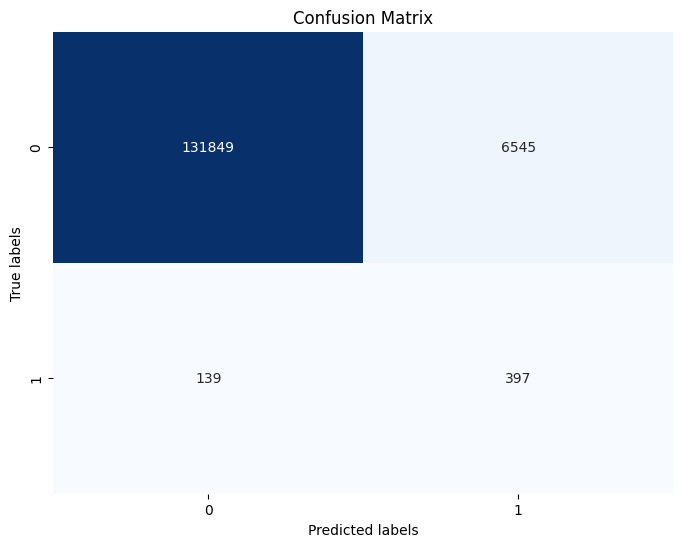

In [167]:
cm = confusion_matrix(y_test, y_pred_ovs)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

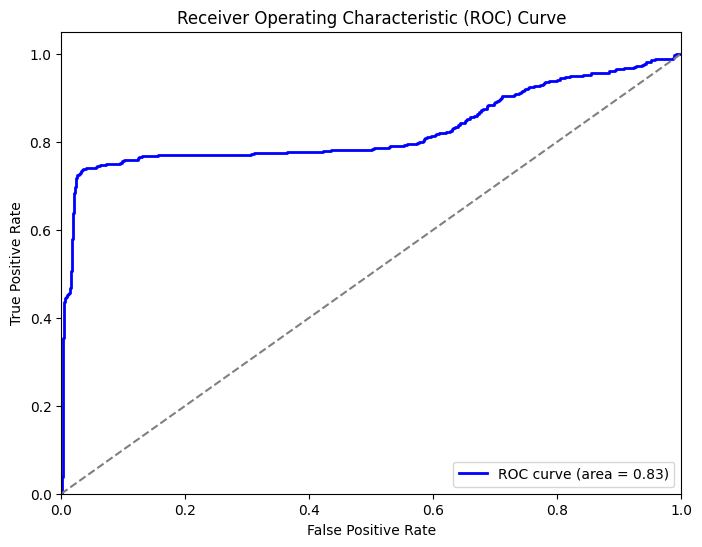

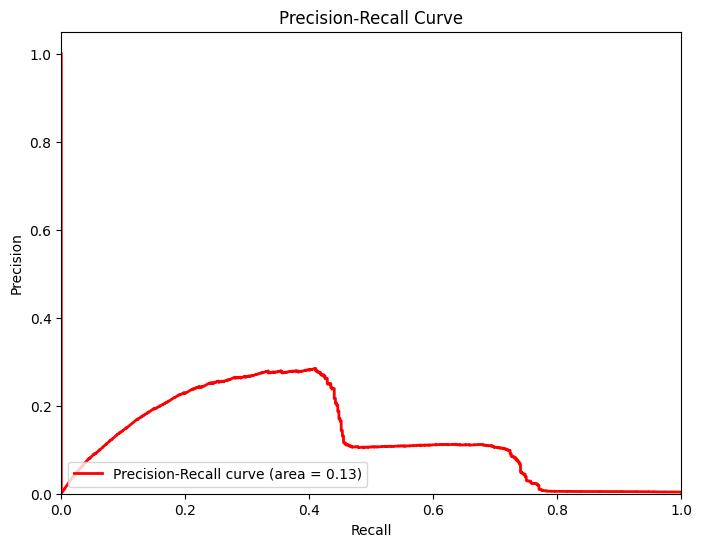

In [168]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area for the positive class
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_ovs[:,1])
roc_auc = auc(fpr, tpr)

# Compute Precision-Recall curve and area for the positive class
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_ovs[:,1])
pr_auc = auc(recall, precision)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='red', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')

plt.show()


https://www.kaggle.com/code/eisgandar/oversampling-methods-on-unbalanced-datasets